## OTT & annealed Sinkhorn

This tutorial aims to provide an experimental illustration of the concepts introduced in the paper [*Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing* (2024)](https://arxiv.org/pdf/2408.11620), in particular comparing classical Sinkhorn versus Annealed Sinkhorn and evaluating the effect of different regularization schedulers using {class}`OTT-JAX's <ott.geometry.epsilon_scheduler.Epsilon>` on the solution and performance.

In [ ]:
pip install ott-jax

In [ ]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.epsilon_scheduler import Epsilon
from ott.solvers.linear import sinkhorn

### OTT and the Sinkhorn algorithm in a nutshell

In the discrete case, we consider two probability vectors $p \in \Delta_n$ and $q \in \Delta_m$, where $\Delta_n := \{ p \in \mathbb{R}^n_+ : p^\top \mathbf{1} = 1 \}$ is the probability simplex. We are given a cost matrix $C \in \mathbb{R}^{n \times m}$, where $C_{ij}$ quantifies the cost of transporting one unit of mass from $p_i$ to $q_j$.

The classical OT problem seeks to find a coupling $\pi \in \mathbb{R}^{n \times m}_+$ that minimizes the total cost while respecting the marginals:

$$
\text{OT}(p, q) := \min_{\pi \in \Gamma(p, q)} \langle C, \pi \rangle,
$$

where $\Gamma(p, q) := \{ \pi \in \mathbb{R}^{n \times m}_+ : \pi \mathbf{1}_m = p, \; \pi^\top \mathbf{1}_n = q \}$ is the set of transport plans.

This problem can be computationally challenging when $n, m$ are large, motivating the use of *entropic regularization*.

### EOT and Sinkhorn algorithm

The entropic OT problem introduces a Kullback-Leibler regularization relative to a reference plan $\pi^{\mathrm{ref}}$, often taken as the uniform matrix:

$$
\text{EOT}_\beta(p, q) := \min_{\pi \in \Gamma(p, q)} \langle C, \pi \rangle + \beta^{-1} \mathrm{KL}(\pi \| \pi^{\mathrm{ref}}),
$$

where $\beta > 0$ is the inverse regularization strength ("inverse temperature"). The KL term smooths the optimization landscape, making the problem easier to solve via the Sinkhorn algorithm.

The optimal solution has the form $\pi = \mathrm{diag}(a) K \mathrm{diag}(b)$ with $K = \exp(-\beta C) \in \mathbb{R}^{n \times m}$, and vectors $a \in \mathbb{R}^n_+$, $b \in \mathbb{R}^m_+$ computed by iteratively enforcing the marginal constraints:

$$
a^{(t)} = \frac{p}{K b^{(t-1)}}, \qquad b^{(t)} = \frac{q}{K^\top a^{(t)}}
$$

These updates alternate KL projections onto the constraints and converge rapidly for moderate values of $\beta$.


### Regularized versus non-regularized optimal transport

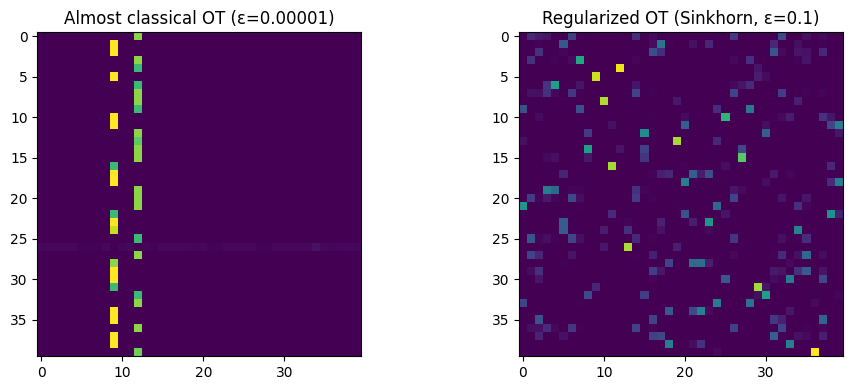

In [43]:
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers.linear import solve

# Two point distributions in R²
# rng = np.random.default_rng(42)
n = 40
x = jnp.array(rng.normal(loc=0.0, scale=1.0, size=(n, 2)))
y = jnp.array(rng.normal(loc=5.0, scale=1.0, size=(n, 2)))

# Geometry with low regularization (close to classical OT)
geom_lowreg = pointcloud.PointCloud(x, y, epsilon=0.00001)
out_lowreg = solve(geom_lowreg)

# Geometry with higher regularization (Sinkhorn)
geom_reg = pointcloud.PointCloud(x, y, epsilon=0.1)
out_reg = solve(geom_reg)

# Display transport matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(out_lowreg.matrix, cmap="viridis")
axs[0].set_title("Almost classical OT (ε=0.00001)")

axs[1].imshow(out_reg.matrix, cmap="viridis")
axs[1].set_title("Regularized OT (Sinkhorn, ε=0.1)")

plt.tight_layout()
plt.show()

Sinkhorn regularization smooths the transport plan. The two images above show us that with a larger epsilon the mass is more spread out and the plan is blurry. With a very small ε (0.001) the solution is sharper and closer to the true OT solution.

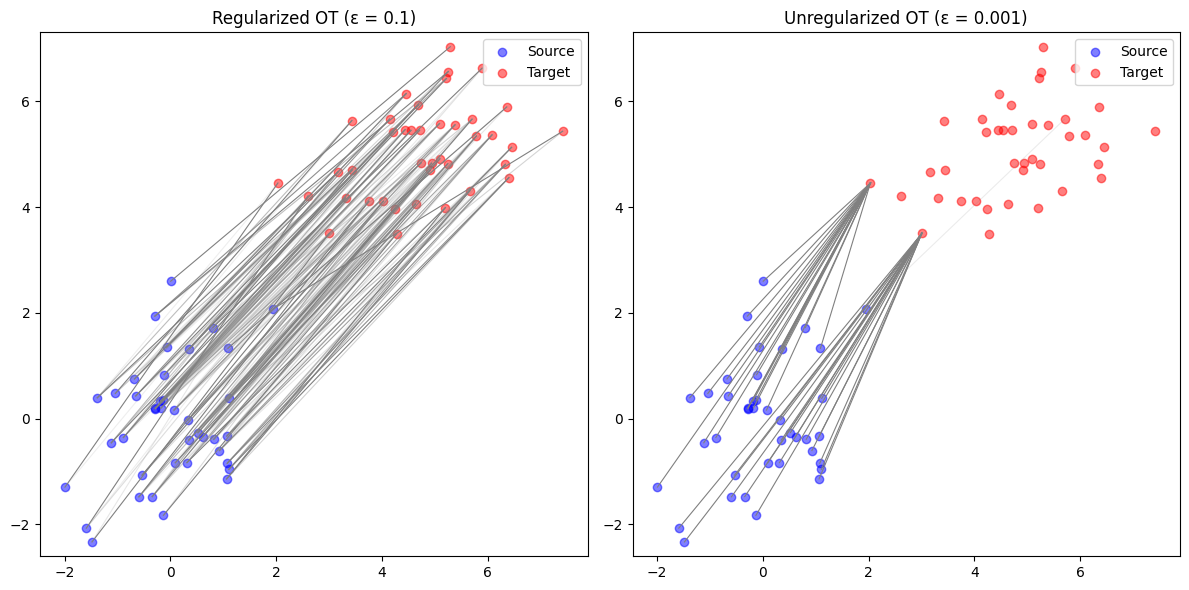

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the transport plan as arrows between points


def plot_transport_plan(
    ax, x, y, transport_matrix, title="Transport Plan", threshold=1e-3
):
    ax.scatter(x[:, 0], x[:, 1], label="Source", color="blue", alpha=0.5)
    ax.scatter(y[:, 0], y[:, 1], label="Target", color="red", alpha=0.5)

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            weight = transport_matrix[i, j]
            if weight > threshold:
                ax.plot(
                    [x[i, 0], y[j, 0]],
                    [x[i, 1], y[j, 1]],
                    color="gray",
                    alpha=min(weight * 100, 1.0),
                    linewidth=0.8,
                )

    ax.set_title(title)
    ax.axis("equal")
    ax.legend()


T_reg_np = np.array(out_reg.matrix)
T_unreg_np = np.array(out_lowreg.matrix)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_transport_plan(axs[0], x, y, T_reg_np, title="Regularized OT (ε = 0.1)")
plot_transport_plan(
    axs[1], x, y, T_unreg_np, title="Unregularized OT (ε = 0.001)"
)
plt.tight_layout()
plt.show()

The plots below compare the transport plans obtained from regularized and unregularized optimal transport.

- On the left, we see the plan obtained using entropic regularization (Sinkhorn algorithm) with $\varepsilon = 0.1$. The plan is more diffuse: many source points transport mass to multiple targets, creating a "blurred" matching.
- On the right, the plan is computed with a much smaller regularization $ \varepsilon = 0.001$, approaching the classical OT solution. The transport becomes sharper and sparser, with mass mostly flowing along one-to-one matches between points.

This illustrates how increasing $\varepsilon $ trades off precision for smoothness and computational stability. The regularized plan can be faster to compute and differentiable, but less interpretable when exact matching is desired.


In [48]:
# Cost of the plan with ε=0.001 (almost no regularization)
cost_lowreg = jnp.sum(out_lowreg.matrix * geom_lowreg.cost_matrix)

# Cost of the plan with ε=0.1
cost_reg = jnp.sum(out_reg.matrix * geom_reg.cost_matrix)

print(f"Cost (ε=0.001, near-classic OT): {cost_lowreg:.4f}")
print(f"Cost (ε=0.1, regularized OT): {cost_reg:.4f}")

Cost (ε=0.001, near-classic OT): 27.0688
Cost (ε=0.1, regularized OT): 49.8362


As expected, the cost of the regularized transport plan is higher than that of the nearly unregularized one. This is the price paid for better numerical stability and faster convergence.

### Annealed sinkhorn

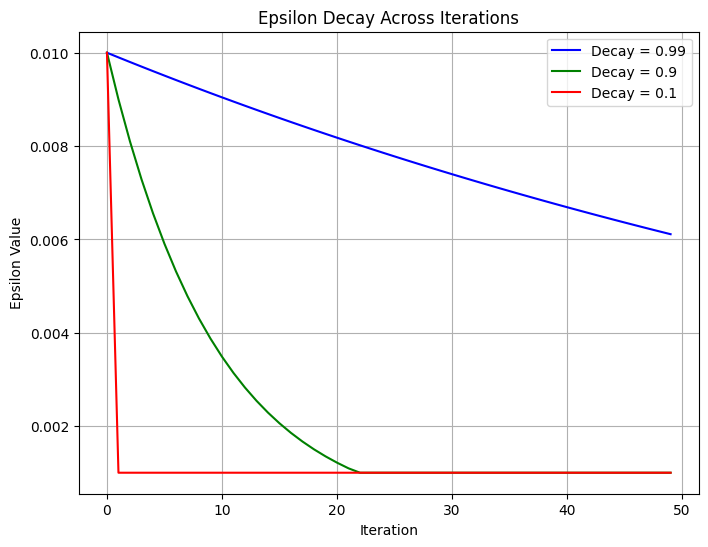

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from ott.geometry.epsilon_scheduler import Epsilon

# Function to collect epsilon values at each iteration


def collect_epsilon_values(scheduler, n_iter=50):
    epsilon_values = []
    for t in range(n_iter):
        epsilon_values.append(scheduler(t))
    return epsilon_values


# different epsilon schedulers with various decay rates
scheduler_1 = Epsilon(target=1e-3, init=10, decay=0.99)
scheduler_09 = Epsilon(target=1e-3, init=10, decay=0.9)
scheduler_01 = Epsilon(target=1e-3, init=10, decay=0.1)

epsilon_1 = collect_epsilon_values(scheduler_1)
epsilon_09 = collect_epsilon_values(scheduler_09)
epsilon_01 = collect_epsilon_values(scheduler_01)

plt.figure(figsize=(8, 6))
plt.plot(range(len(epsilon_1)), epsilon_1, label="Decay = 0.99", color="blue")
plt.plot(range(len(epsilon_09)), epsilon_09, label="Decay = 0.9", color="green")
plt.plot(range(len(epsilon_01)), epsilon_01, label="Decay = 0.1", color="red")

plt.xlabel("Iteration")
plt.ylabel("Epsilon Value")
plt.title("Epsilon Decay Across Iterations")
plt.legend()
plt.grid(True)
plt.show()

This plot shows how the regularization parameter epsilon decays over iterations for different decay rates, with the `ott.geometry.epsilon_scheduler.Epsilon` class . A slower decay (e.g. 0.99) keeps the algorithm more stable longer, while a faster decay (e.g. 0.1) leads to quicker convergence but may cause instability.

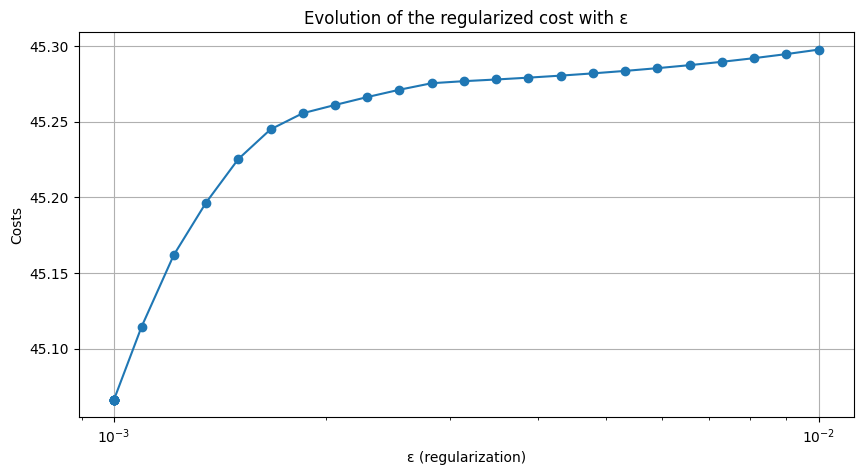

In [ ]:
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.epsilon_scheduler import Epsilon
from ott.solvers.linear import solve

# Data
rng = np.random.default_rng(42)
n = 30
x = jnp.array(rng.normal(loc=0.0, scale=1.0, size=(n, 2)))
y = jnp.array(rng.normal(loc=5.0, scale=1.0, size=(n, 2)))

scheduler = Epsilon(target=1e-3, init=10.0, decay=0.9)


# Annealing
n_iter = 30
plans = []
costs = []
epsilons = []

for i in range(n_iter):
    eps = scheduler(i)
    geom = pointcloud.PointCloud(x, y, epsilon=eps)
    out = solve(geom)
    plans.append(np.array(out.matrix))
    costs.append(float(out.reg_ot_cost))
    epsilons.append(float(eps))

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(epsilons, costs, marker="o")
plt.xlabel("ε (regularization)")
plt.ylabel("Costs")
plt.title("Evolution of the regularized cost with ε")
plt.xscale("log")
plt.grid(True)
plt.show()

Here we compute entropic optimal transport plans between two point clouds with decreasing regularization ε. The plot shows how the regularized OT cost evolves as ε decreases.
It is normal that we see the regularized OT cost decrease as ε decreases, since lower regularization allows the transport plan to better match the true optimal cost.

---

In [ ]:
import time

import jax.numpy as jnp
import numpy as np
from jax import random
from numpy import random as npr

import matplotlib.pyplot as plt

# Experimental configuration
m = 600
n = 600

# Generate simulated point clouds
key = random.PRNGKey(0)
key, subkey = random.split(key)
x = npr.randn(m, 2) * 0.2 + jnp.array([0.0, 0.0])

key, subkey = random.split(key)
y = npr.randn(n, 2) * 0.2 + jnp.array([1.0, 1.0])

# Squared Euclidean cost function


def cost_fn(x, y):
    return jnp.sum((x - y) ** 2)


# Compute the cost matrix
cost_matrix = jnp.array([[cost_fn(xi, yj) for yj in y] for xi in x])

# Normalize the cost matrix to have unit oscillation
c_osc = jnp.max(cost_matrix) - jnp.min(cost_matrix)
cost_matrix_normalized = cost_matrix / c_osc

# uniform marginal distributions
p = jnp.ones(m) / m
q = jnp.ones(n) / n

In [ ]:
# Approximation of the true OT cost with a manual implementation of the Sinkhorn algorithm.
# We use a lot (5000) of iterations and a tiny (0.001) epsilon to approximate the true OT cost.
# The cost obtained will be used as a reference in the next steps of this notebook.
cost_matrix_normalized = cost_matrix / jnp.max(cost_matrix)

epsilon_ot_approx = 0.006
max_iter_ot_approx = 200

# Sinkhorn algorithm


def sinkhorn_iterations(cost_matrix, p, q, epsilon, max_iterations):
    K = jnp.exp(-cost_matrix / epsilon)
    a = jnp.ones(p.shape)
    b = jnp.ones(q.shape)

    costs = []

    # Sinkhorn iterations as in the paper
    for i in range(20):

        # Update a :
        a = p / (K @ b)

        # Update b :
        b = q / (K.T @ a)

        # Compute the transport plan
        pi_t = jnp.diag(a) @ K @ jnp.diag(b)

        # Compute the cost
        cost_t = jnp.sum(cost_matrix * pi_t)
        costs.append(cost_t)
        if i % 5 == 0:
            print(i)
            print(f"Iter {i}: Cost = {cost_t}")

    return jnp.array(costs)


print(
    f"\nApproximation of the exact OT cost with epsilon={epsilon_ot_approx} and 5000 iterations..."
)

start_time = time.time()
costs_ot_approx = sinkhorn_iterations(
    cost_matrix_normalized, p, q, epsilon_ot_approx, 2000
)
ot_approx_cost = costs_ot_approx[-1]  # The last cost as the approximation
end_time = time.time()
print(
    f"Approximation of the OT cost obtained : {ot_approx_cost:.4f} (in {end_time - start_time:.2f} seconds)"
)


Approximation of the exact OT cost with epsilon=0.006 and 5000 iterations...
0
Iter 0: Cost = 0.1126275286078453
5
Iter 5: Cost = 0.2879107594490051
10
Iter 10: Cost = 0.3120492696762085
15
Iter 15: Cost = 0.31457987427711487
Approximation of the OT cost obtained : 0.3148 (in 0.33 seconds)


#### Speed-accuracy trade-off


Running Sinkhorn with different epsilon values to illustrate the trade-off...
  - Running with epsilon=0.1 for 20 iterations...
0
Iter 0: Cost = 0.32542601227760315
5
Iter 5: Cost = 0.334458589553833
10
Iter 10: Cost = 0.334458589553833
15
Iter 15: Cost = 0.334458589553833
    Completed in 0.34 seconds.
  - Running with epsilon=0.03 for 20 iterations...
0
Iter 0: Cost = 0.26467299461364746
5
Iter 5: Cost = 0.32810506224632263
10
Iter 10: Cost = 0.3281085193157196
15
Iter 15: Cost = 0.3281085193157196
    Completed in 0.35 seconds.
  - Running with epsilon=0.01 for 20 iterations...
0
Iter 0: Cost = 0.13911591470241547
5
Iter 5: Cost = 0.31499606370925903
10
Iter 10: Cost = 0.31985822319984436
15
Iter 15: Cost = 0.31997454166412354
    Completed in 0.30 seconds.


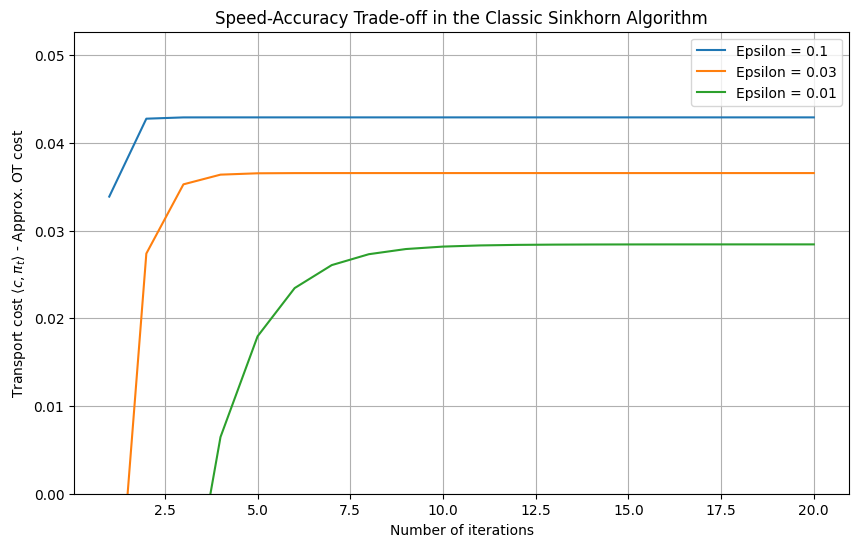


Speed-accuracy trade-off
Each curve corresponds to a run of Sinkhorn with a fixed regularization parameter epsilon.
Smaller epsilon (larger beta) achieves a lower transport cost (closer to exact OT),
but requires more iterations to converge.
This behavior matches the dashed lines in Figure 1 of the paper, showing the Pareto frontier.


In [ ]:
# the Sinkhorn speed-accuracy trade-off

import time

import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

epsilon_values = [0.1, 0.03, 0.01]  # Different regularization strengths
max_iterations_plot = 20  # Number of iterations to track for plotting

plt.figure(figsize=(10, 6))

all_costs_paths = {}
for epsilon in epsilon_values:
    print(
        f"  - Running with epsilon={epsilon} for {max_iterations_plot} iterations..."
    )
    start_time = time.time()
    costs_path = sinkhorn_iterations(
        cost_matrix_normalized, p, q, epsilon, max_iterations_plot
    )
    end_time = time.time()
    print(f"    Completed in {end_time - start_time:.2f} seconds.")
    all_costs_paths[epsilon] = costs_path

    # Plot cost over iterations, shifted by the approximate OT cost for comparison
    plt.plot(
        range(1, max_iterations_plot + 1),
        costs_path - ot_approx_cost,
        label=f"Epsilon = {epsilon}",
    )

plt.xlabel("Number of iterations")
plt.ylabel("Transport cost $\\langle c, \\pi_t \\rangle$ - Approx. OT cost")
plt.title("Speed-Accuracy Trade-off in the Classic Sinkhorn Algorithm")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

print("\nSpeed-accuracy trade-off")
print(
    "Each curve corresponds to a run of Sinkhorn with a fixed regularization parameter epsilon."
)
print(
    "Smaller epsilon (larger beta) achieves a lower transport cost (closer to exact OT),"
)
print("but requires more iterations to converge.")

Each curve shows how the transport cost decreases over iterations for a fixed regularization value
𝜖
ϵ. As expected, smaller
𝜖
ϵ values yield more accurate (lower) costs but converge more slowly, illustrating the speed-accuracy trade-off of the Sinkhorn algorithm.

#### Valid vs invalid schedules

In [ ]:
import time

import jax.numpy as jnp


def sinkhorn_with_schedule(cost_matrix, p, q, epsilon_schedule, max_iterations):
    a = jnp.ones(p.shape)
    b = jnp.ones(q.shape)
    costs = []

    for t in range(max_iterations):
        epsilon = epsilon_schedule(t)
        K = jnp.exp(-cost_matrix / epsilon)

        a = p / (K @ b)
        b = q / (K.T @ a)

        pi_t = jnp.diag(a) @ K @ jnp.diag(b)
        cost_t = jnp.sum(cost_matrix * pi_t)
        costs.append(cost_t)

        if t % 10 == 0:
            print(f"Iter {t}: ε = {epsilon:.4f}, Cost = {cost_t:.4f}")

    return jnp.array(costs)


# Schedules


def epsilon_valid(t):
    return 1.0 / jnp.log(t + 2.0)


def epsilon_invalid(t):
    return 1.0 / (t + 1.0)


cost_matrix_normalized = cost_matrix / jnp.max(cost_matrix)

max_iter = 200
print("\n==> Running valid annealing schedule (slow decay)...")
start = time.time()
costs_valid = sinkhorn_with_schedule(
    cost_matrix_normalized, p, q, epsilon_valid, max_iter
)
end = time.time()
print(
    f"Final cost (valid): {costs_valid[-1]:.4f} (in {end - start:.2f} seconds)"
)

print("\n==> Running invalid annealing schedule (fast decay)...")
start = time.time()
costs_invalid = sinkhorn_with_schedule(
    cost_matrix_normalized, p, q, epsilon_invalid, max_iter
)
end = time.time()
print(
    f"Final cost (invalid): {costs_invalid[-1]:.4f} (in {end - start:.2f} seconds)"
)


==> Running VALID annealing schedule (slow decay)...
Iter 0: ε = 1.4427, Cost = 0.3350
Iter 10: ε = 0.4024, Cost = 0.3345
Iter 20: ε = 0.3235, Cost = 0.3343
Iter 30: ε = 0.2885, Cost = 0.3341
Iter 40: ε = 0.2675, Cost = 0.3341
Iter 50: ε = 0.2531, Cost = 0.3340
Iter 60: ε = 0.2423, Cost = 0.3339
Iter 70: ε = 0.2338, Cost = 0.3339
Iter 80: ε = 0.2269, Cost = 0.3338
Iter 90: ε = 0.2212, Cost = 0.3338
Iter 100: ε = 0.2162, Cost = 0.3338
Iter 110: ε = 0.2119, Cost = 0.3337
Iter 120: ε = 0.2082, Cost = 0.3337
Iter 130: ε = 0.2048, Cost = 0.3337
Iter 140: ε = 0.2018, Cost = 0.3337
Iter 150: ε = 0.1990, Cost = 0.3336
Iter 160: ε = 0.1966, Cost = 0.3336
Iter 170: ε = 0.1943, Cost = 0.3336
Iter 180: ε = 0.1922, Cost = 0.3336
Iter 190: ε = 0.1902, Cost = 0.3336
Final cost (VALID): 0.3335 (in 4.38 seconds)

==> Running INVALID annealing schedule (fast decay)...
Iter 0: ε = 1.0000, Cost = 0.3349
Iter 10: ε = 0.0909, Cost = 0.3306
Iter 20: ε = 0.0476, Cost = 0.3268
Iter 30: ε = 0.0323, Cost = 0.32

We observe that the "invalid" annealing schedule — which decreases $\varepsilon$ too rapidly — leads to `nan` values in the Sinkhorn cost after a certain number of iterations.

This typically occurs because the kernel matrix
$
K = \exp\left(-\frac{C}{\varepsilon}\right)
$
becomes numerically unstable when $\varepsilon$ approaches zero too quickly. Specifically, for small $\varepsilon$, the entries of $K$ become extremely small or even zero in floating-point precision, leading to divisions by zero or underflows during the dual updates:$
a^{(t)} = \frac{p}{K b^{(t-1)}}, \quad b^{(t)} = \frac{q}{K^\top a^{(t)}}
$

This numerical instability results in `nan` values in the Sinkhorn cost.

This illustrates the theoretical result from the *Annealed Sinkhorn* paper (2024): for the algorithm to converge to the true optimal transport (OT) solution, it is not sufficient that $\beta_t = 1/\varepsilon_t \to \infty$. It is also necessary that the increase in $\beta_t$ becomes smaller and smaller:

$$
\beta_t \to \infty \quad \text{and} \quad \beta_t - \beta_{t-1} \to 0
$$
When this condition is violated (i.e., $\varepsilon_t$ decays too fast), the algorithm may diverge or produce unstable results.


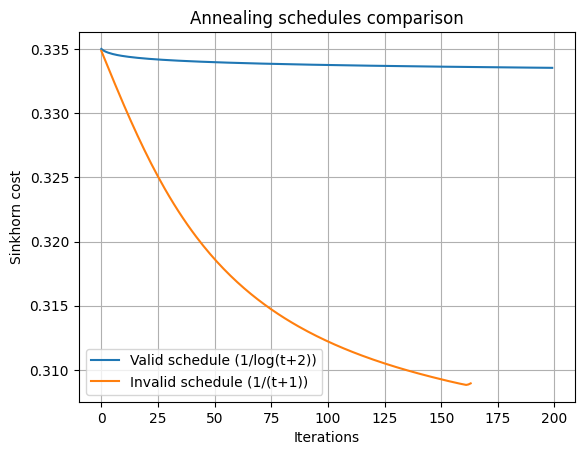

In [60]:
import matplotlib.pyplot as plt

plt.plot(costs_valid, label="Valid schedule (1/log(t+2))")
plt.plot(costs_invalid, label="Invalid schedule (1/(t+1))")
plt.xlabel("Iterations")
plt.ylabel("Sinkhorn cost")
plt.legend()
plt.title("Annealing schedules comparison")
plt.grid(True)
plt.show()